## 1 - Installs and imports

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 37.2 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# Import generic wrappers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from scipy.special import softmax
from collections import defaultdict
import torch
import urllib
from sklearn.metrics import classification_report

## 2 - Load the model and the tokenizer

In [3]:
# Define the model repo
model_name = "monsoon-nlp/hindi-bert" 
#model_name = "monsoon-nlp/hindi-tpu-electra"

# Download pytorch model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/56.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at monsoon-nlp/hindi-bert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/hindi-bert and are newly initialized: ['classifier.dense.weight', 'classif

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/593k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## 3 - Define training parameters 

In [4]:
LR = 2e-5
EPOCHS = 3
BATCH_SIZE = 8
MAX_TRAINING_EXAMPLES = -1 # set this to -1 if you want to use the whole training set

## 4 - Load UMSAB dataset (for fine-tuning)

In [5]:
files = """test_labels.txt
test_text.txt
train_labels.txt
train_text.txt
val_labels.txt
val_text.txt""".split('\n')

In [6]:
def fetch_data(language, files):
 dataset = defaultdict(list)
 for infile in files:
   thisdata = infile.split('/')[-1].replace('.txt','')
   dataset_url = f"https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/{language}/{infile}"
   print(f'Fetching from {dataset_url}')
   with urllib.request.urlopen(dataset_url) as f:
     for line in f:
       if thisdata.endswith('labels'):
         dataset[thisdata].append(int(line.strip().decode('utf-8')))
       else:
         dataset[thisdata].append(line.strip().decode('utf-8'))
 return dataset

In [7]:
# Load the Hindi dataset
umsab_dataset = fetch_data('hindi', files)

Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/test_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/test_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/train_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/train_text.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/val_labels.txt
Fetching from https://raw.githubusercontent.com/cardiffnlp/xlm-t/main/data/sentiment/hindi/val_text.txt


In [8]:
train_text = umsab_dataset ['train_text']
train_labels = umsab_dataset ['train_labels']

val_text = umsab_dataset ['val_text']
val_labels = umsab_dataset ['val_labels']

test_text = umsab_dataset ['test_text']
test_labels = umsab_dataset ['test_labels']

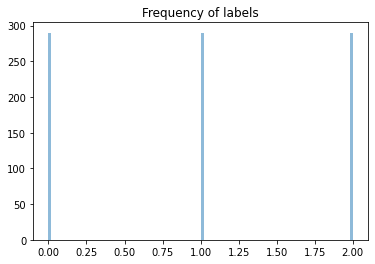

In [10]:
plt.hist(test_labels, bins=100, alpha=0.5)
plt.title("Frequency of labels")
plt.show()

## 5 - Encoding the datasets

In [11]:
train_encodings = tokenizer(train_text, truncation=True, padding=True)
val_encodings = tokenizer(val_text, truncation=True, padding=True)
test_encodings = tokenizer(test_text, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [12]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings,train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

## 6 - Fine-tuning the model

In [13]:
training_args = TrainingArguments(
    output_dir='./results',                   # output directory
    num_train_epochs=EPOCHS,                  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # batch size for evaluation
    warmup_steps=100,                         # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                        # strength of weight decay
    logging_dir='./logs',                     # directory for storing logs
    logging_steps=10,                         # when to print log
    load_best_model_at_end=True,              # load or not best model at the end
    evaluation_strategy = "no",               # provided in order the evaluation and save strategy to match
    save_strategy = 'no'
)

num_labels = len(train_labels)

In [14]:
trainer = Trainer(
    model=model,                              # the instantiated 🤗 Transformers model to be trained
    args=training_args,                       # training arguments, defined above
    train_dataset=train_dataset,              # training dataset
    eval_dataset=val_dataset                  # evaluation dataset
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1839
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 690


Step,Training Loss
10,1.099900
20,1.096900
30,1.105700
40,1.102500
50,1.095600
60,1.094000
70,1.097900
80,1.104000
90,1.104900
100,1.098900




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=690, training_loss=1.0985484026480412, metrics={'train_runtime': 3787.3857, 'train_samples_per_second': 1.457, 'train_steps_per_second': 0.182, 'total_flos': 112857920004456.0, 'train_loss': 1.0985484026480412, 'epoch': 3.0})

Save the trained model

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

trainer.save_model("/content/gdrive/My Drive/Models") # save best model

Saving model checkpoint to /content/gdrive/My Drive/Models


Mounted at /content/gdrive


Configuration saved in /content/gdrive/My Drive/Models/config.json
Model weights saved in /content/gdrive/My Drive/Models/pytorch_model.bin


## 7 - Evaluation of the fine-tuned model on UMSAB test dataset

In [16]:
test_preds_raw, test_labels , _ = trainer.predict(test_dataset)
test_preds = np.argmax(test_preds_raw, axis=-1)
print(classification_report(test_labels, test_preds, digits=3))

***** Running Prediction *****
  Num examples = 870
  Batch size = 8


              precision    recall  f1-score   support

           0      0.467     0.297     0.363       290
           1      0.432     0.434     0.433       290
           2      0.373     0.507     0.430       290

    accuracy                          0.413       870
   macro avg      0.424     0.413     0.409       870
weighted avg      0.424     0.413     0.409       870



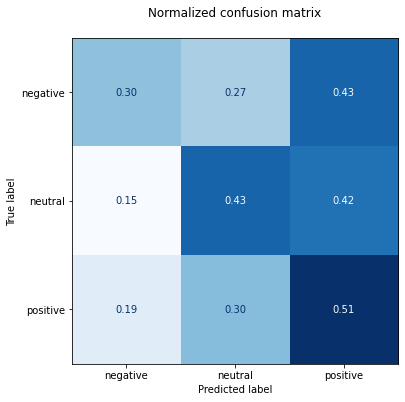

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix\n")
    plt.show()

plot_confusion_matrix(test_preds, test_labels, labels=['negative', 'neutral', 'positive'])

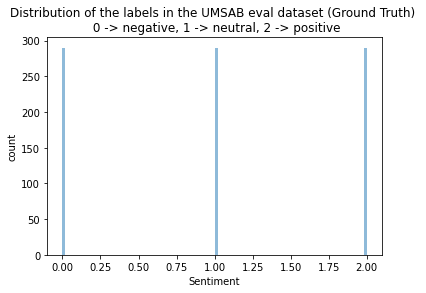

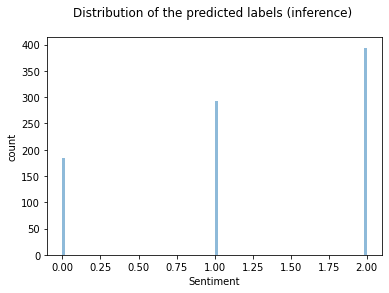

In [19]:
plt.figure()
plt.hist(test_labels, bins=100, alpha=0.5)
plt.title('Distribution of the labels in the UMSAB eval dataset (Ground Truth) \n 0 -> negative, 1 -> neutral, 2 -> positive')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()

plt.figure()
plt.hist(test_preds, bins=100, alpha=0.5)
plt.title('Distribution of the predicted labels (inference) \n ')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()